In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns



# Загрузим и предобработаем при необходимости данные из тренировочного датасета

In [2]:
df = pd.read_csv('train.csv')
df.head(5)

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
0,0,40.0,0.0,1400.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,63.0
1,1,48.0,4.0,2850.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,86.0
2,2,39.0,0.0,1200.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0
3,3,46.0,5.0,1400.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0
4,4,43.0,1.0,1500.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,59.0


Смотрим типы данных в столбцах. Изучаем на предмет пропусков и аномальных значений.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   10000 non-null  int64  
 1   age                  10000 non-null  float64
 2   years_of_experience  10000 non-null  float64
 3   lesson_price         10000 non-null  float64
 4   qualification        10000 non-null  float64
 5   physics              10000 non-null  float64
 6   chemistry            10000 non-null  float64
 7   biology              10000 non-null  float64
 8   english              10000 non-null  float64
 9   geography            10000 non-null  float64
 10  history              10000 non-null  float64
 11  mean_exam_points     10000 non-null  float64
dtypes: float64(11), int64(1)
memory usage: 937.6 KB


In [4]:
df.describe()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4999.50000,45.878000,1.986800,1699.105000,1.719500,0.375000,0.132900,0.109600,0.053700,0.032100,0.019400,64.340800
std,2886.89568,8.043929,1.772213,524.886654,0.792264,0.484147,0.339484,0.312406,0.225436,0.176274,0.137933,13.536823
min,0.00000,23.000000,0.000000,200.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32.000000
25%,2499.75000,40.000000,0.000000,1300.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,55.000000
50%,4999.50000,46.000000,2.000000,1500.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,63.000000
75%,7499.25000,51.000000,3.000000,2150.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,73.000000
max,9999.00000,68.000000,10.000000,3950.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,100.000000


Проанализируем основные значения построив несколько графиков

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001BCAD5AD8C8>,
      dtype=object)

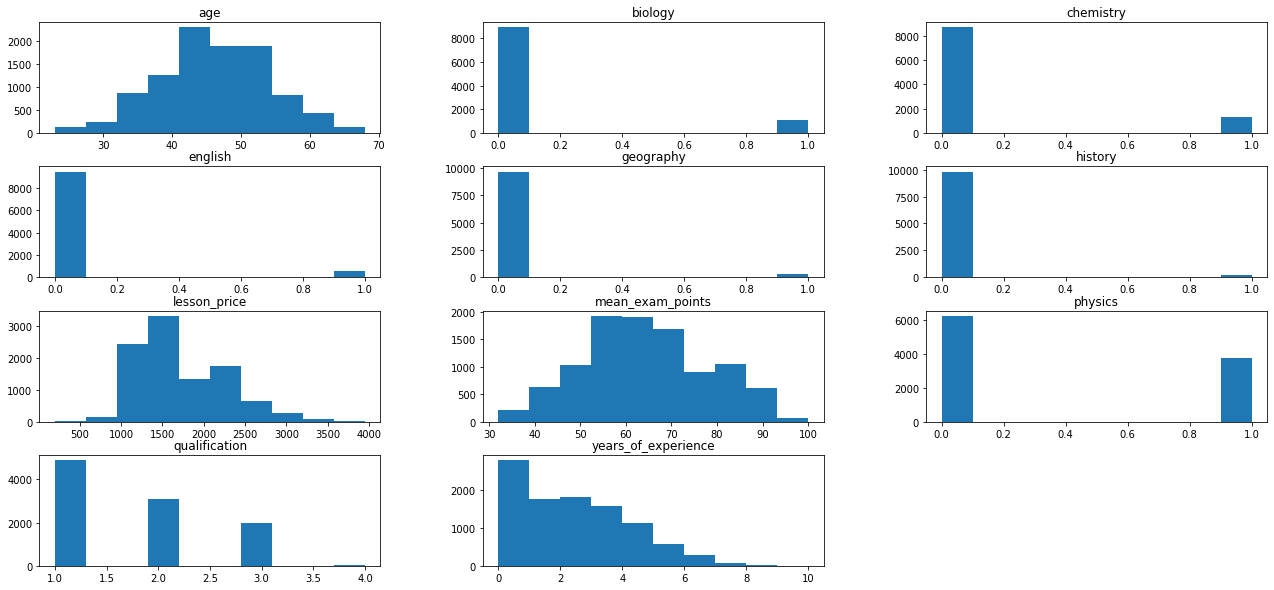

In [5]:
df[['age', 'years_of_experience', 'lesson_price', 'qualification', 'physics', 
'chemistry', 'biology', 'english', 'geography', 'history', 
'mean_exam_points']].hist(figsize=(22,10),bins = 10, grid = False, log= False)

Выберем колонки, которые мы будем использовать в качестве признаков для обучения модели и целевую переменную

In [6]:
TARGET_NAME = 'mean_exam_points'
FEATURE_NAMES = ['age', 'years_of_experience', 'lesson_price', 'qualification',
       'physics', 'chemistry', 'biology', 'english', 'geography', 'history']

In [7]:
# Теперь приведём наши данные к формату np.array
X = df[FEATURE_NAMES].values
y = df[TARGET_NAME].values

print(X.shape, y.shape)

(10000, 10) (10000,)


# Реализуем алгоритм градиентного бустинга

In [8]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [9]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        #  найдем значение как среднее по выборке   
        prediction = np.mean(self.labels)
        return prediction

In [10]:
# И класс дерева
class Tree:

  def __init__(self, max_depth=50):
    self.max_depth = max_depth
    self.tree = None

  # Расчёт дисперсии значений
  def dispersion(self, labels):
    return np.std(labels)

  # Расчет качества

  def quality(self, left_labels, right_labels, current_dispersion):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_dispersion - p * self.dispersion(left_labels) - (1 - p) * self.dispersion(right_labels)

    # Разбиение датасета в узле

  def split(self, data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

    # Нахождение наилучшего разбиения

  def find_best_split(self, data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_dispersion = self.dispersion(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
      # будем проверять только уникальные значения признака, исключая повторения
      t_values = np.unique([row[index] for row in data])
      
      for t in t_values:
        true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)
        #  пропускаем разбиения, в которых в узле остается менее 5 объектов
        if len(true_data) < min_leaf or len(false_data) < min_leaf:
          continue
        
        current_quality = self.quality(true_labels, false_labels, current_dispersion)
        
        #  выбираем порог, на котором получается максимальный прирост качества
        if current_quality > best_quality:
          best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

    # Построение дерева с помощью рекурсивной функции

  def build_tree(self, data, labels, tree_depth, max_depth):

    quality, t, index = self.find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
      return Leaf(data, labels)

    # Базовый случай (2) - прекращаем рекурсию, когда достигнута максимальная глубина дерева
    if tree_depth >= max_depth:
      return Leaf(data, labels)

    # Увеличиваем глубину дерева на 1
    tree_depth += 1

    true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = self.build_tree(true_data, true_labels, tree_depth, max_depth)
    false_branch = self.build_tree(false_data, false_labels, tree_depth, max_depth)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

  def predict_object(self, obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
      answer = node.prediction
      return answer

    if obj[node.index] <= node.t:
      return self.predict_object(obj, node.true_branch)
    else:
      return self.predict_object(obj, node.false_branch)

  def predict(self, data):
    
    val = []
    for obj in data:
      prediction = self.predict_object(obj, self.tree)
      val.append(prediction)
    return val

  def fit(self, data, labels):
    self.tree = self.build_tree(data, labels, 0, self.max_depth)
    return self

In [11]:
class GradientBoosting:
  
  def __init__(self, n_trees, max_depth, coefs, eta):
    self.n_trees = n_trees
    self.max_depth = max_depth
    self.coefs = coefs
    self.eta = eta
    self.trees = []

  def bias(self, y, z):
    return (y - z)

  def fit(self, X_train, y_train):
    
    # Деревья будем записывать в список
    trees = []
    
    for i in range(self.n_trees):
        tree = Tree(max_depth=self.max_depth)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(self.trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
        else:
            # Получим ответы на текущей композиции
            target = self.predict(X_train)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            bias = self.bias(y_train, target)
            tree.fit(X_train, bias)

        self.trees.append(tree)
        
    return self

  def predict(self, X):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([self.eta* coef * alg.predict([x])[0] for alg, coef in zip(self.trees, self.coefs)]) for x in X])

In [12]:
def r_2(y_pred, y_true):
  numerator = ((y_true - y_pred) ** 2).sum(axis=0, dtype=np.float64)
  denominator = ((y_true - np.average(y_true)) ** 2).sum(axis=0,
                                                          dtype=np.float64)
  return 1 - (numerator / denominator)

Сделаем функцию для наглядного сравнения результатов, с графиками

In [13]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r_2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r_2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

# Проверим качество предсказания модели на обучающей и валидационной выборке

In [14]:
train_data, test_data, train_labels, test_labels = train_test_split(X, y, 
                                                                    test_size = 0.3,
                                                                    random_state = 13)

In [15]:
# Число деревьев в ансамбле
n_trees = 10

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 5

# Шаг
eta = 1

In [16]:
gb = GradientBoosting(n_trees, max_depth, coefs, eta)
gb.fit(train_data, train_labels)
train_answers = np.round(gb.predict(train_data), 0)
test_answers = np.round(gb.predict(test_data), 0)

Train R2:	0.767
Test R2:	0.793


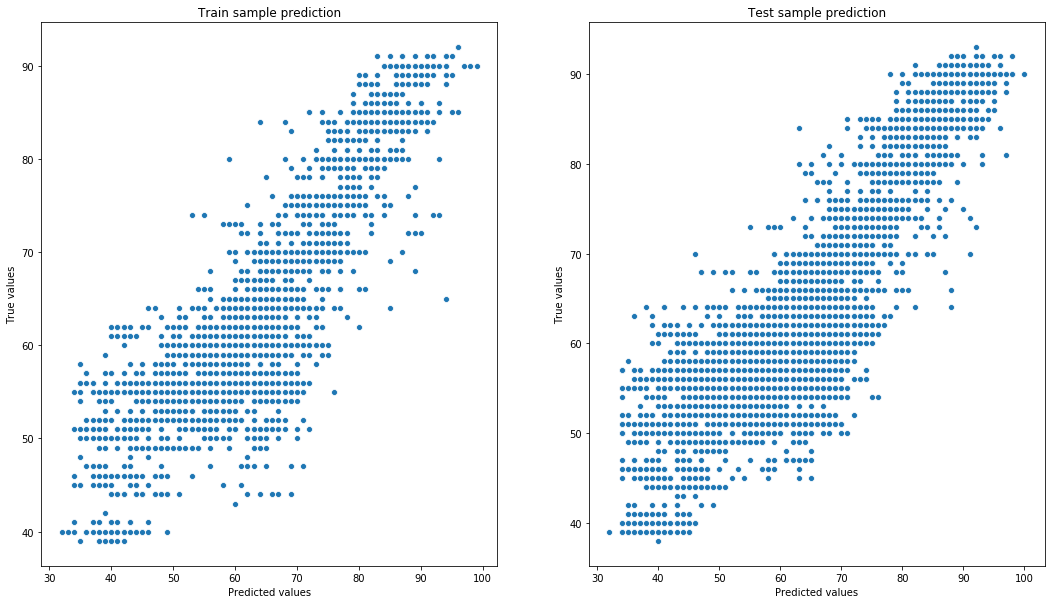

In [17]:
evaluate_preds(test_answers, test_labels, train_answers, train_labels)

# Модель показала достаточное качество как на тренировочной так и на валидационной выборке, так что обучим финальную модель на всём датасете

In [18]:
gb_final = GradientBoosting(n_trees, max_depth, coefs, eta)
gb_final.fit(X, y)

# Загрузим тестовый датасет и сделаем для него предсказания

In [19]:
df_test = pd.read_csv('test.csv')

In [20]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   10000 non-null  int64  
 1   age                  10000 non-null  float64
 2   years_of_experience  10000 non-null  float64
 3   lesson_price         10000 non-null  float64
 4   qualification        10000 non-null  float64
 5   physics              10000 non-null  float64
 6   chemistry            10000 non-null  float64
 7   biology              10000 non-null  float64
 8   english              10000 non-null  float64
 9   geography            10000 non-null  float64
 10  history              10000 non-null  float64
dtypes: float64(10), int64(1)
memory usage: 859.5 KB


In [21]:
# Теперь приведём наши данные к формату np.array
X_test = df_test[FEATURE_NAMES].values

print(X_test.shape)

(10000, 10)


In [22]:
test_pred = np.round(gb_final.predict(X_test), 0)

In [23]:
submissions = pd.concat([df_test['Id'], pd.Series(test_pred)], axis=1)
submissions = submissions.rename(columns={0: 'mean_exam_points'})
submissions.head()

,Id,mean_exam_points
0,10000,56.0
1,10001,63.0
2,10002,50.0
3,10003,91.0
4,10004,90.0


In [25]:
submissions.to_csv('SFilkin_predictions.csv', sep=',', index=None)